In [1]:
%cd ..
%pwd

/home/guilherme/scantensus-sdy


'/home/guilherme/scantensus-sdy'

In [2]:
from pathlib import Path

from src.utils.matt_heatmap import UnityMakeHeatmaps
from src.pressure_damping.pretransformations import PretransformationsModule
from src.pressure_damping.image_to_image_dataset import UnityImageToImageDataset

import numpy as np
import torch
import torchvision

from matplotlib import cm
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive

import PIL
import PIL.Image

In [27]:
projs = [
    'imp-coro-flow-inv',
    'imp-coro-shunshin-sdy-flow-bad',
    'imp-coro-shunshin-sdy-flow-good',
    'imp-coro-shunshin-sdy-flow-diff'
]

dataset = UnityImageToImageDataset(
        project_codes=projs,
        crop_shape=(512, 512),
        output_shape=(512, 512),
        firebase_certificate=Path('.firebase.json'),
        debug_mode=False
)

In [28]:
image, T, (height_shift, width_shift), labels = dataset[10]

2024-02-04 12:14:55.688 | DEBUG    | src.pressure_damping.image_to_image_dataset:_read_image_into_t:187 - https://storage.googleapis.com/scantensus/fiducial/imp-coro-flow-inv~clusters~Patient_5~Screen_Shot_2019-08-21_at_18.48.30.png: Successfully loaded


In [29]:
def render_torch_image(image: torch.Tensor) -> PIL.Image:
    return torchvision.transforms.ToPILImage()(image.to(torch.uint8).squeeze()).convert('RGBA')

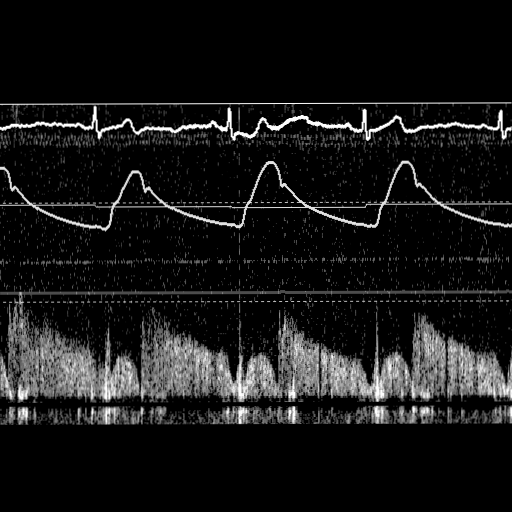

In [30]:
render_torch_image(image)

In [33]:
heatmap_gen = UnityMakeHeatmaps(
    keypoint_names=['curve-flow'],
    image_crop_size=dataset.crop_shape,
    image_out_size=dataset.output_shape
)

heatmaps, weights = heatmap_gen.forward(
    label_data=[labels],
    label_height_shift=[height_shift],
    label_width_shift=[width_shift],
    transform_matrix=[T],
)

/tmp/ipykernel_2704912/74060213.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet_map = cm.get_cmap('jet')


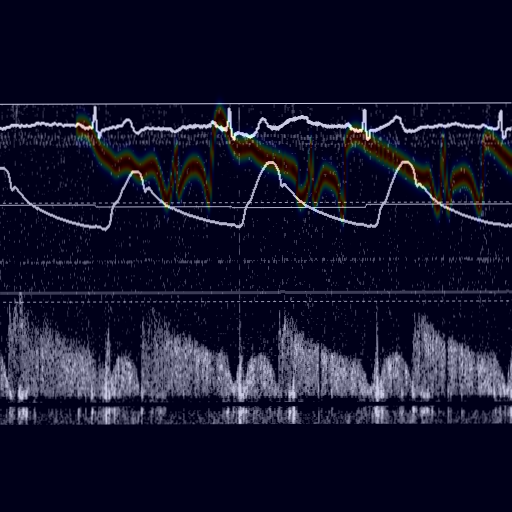

In [34]:
transformed_image = torchvision.transforms.ToPILImage()(image.to(torch.uint8).squeeze()).convert('RGBA')

heatmap = heatmaps[0].squeeze()
jet_map = cm.get_cmap('jet')

heatmap_jetted = PIL.Image.fromarray((jet_map(heatmap.numpy()) * 255).astype(np.uint8))
heatmap_jetted = heatmap_jetted.convert('RGBA').resize(transformed_image.size)

blended = PIL.Image.blend(transformed_image, heatmap_jetted, alpha=0.2)

blended